In [1]:
!pip install scikit-learn

# 군집을 사용한 준지도 학습

군집의 또 다른 사용 사례는 레이블이 지정되지 않은 샘플이 많고 레이블이 지정된 샘플이 매우 적은 경우의 준지도 학습

숫자 0에서 9까지를 나타내는 1,797개의 8×8 흑백 이미지가 포함된 MNIST와 유사한 데이터셋인 간단한 digits 데이터셋을 활용

In [2]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)
X_train, y_train = X_digits[:1200], y_digits[:1200]
X_test, y_test = X_digits[1200:], y_digits[1200:]

### 초반 70개의 샘플에 레이블링하여 학습

학습결과 0.80

In [3]:
from sklearn.linear_model import LogisticRegression

n_labeled = 70
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8023450586264657

## 1200개 train  데이터셋을 사용하여 학습

학습 결과0.916

In [4]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.916247906197655

## k-means로 70개의 군집 대표를 이용하여 학습

70개의 군집을 만들고 centroid에 가까운 이미지를 대표 이미지로 분류하여

레이블을 붙여주고 이 70개 대표이미지로 학습

학습결과 0.894

In [5]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k = n_labeled
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
#X_digits_dist
#X_digits_dist.shape
representative_digit_idx = X_digits_dist.argmin(axis=0)
representative_digit_idx
X_representative_digits = X_train[representative_digit_idx]

In [6]:
X_digits_dist = kmeans.fit_transform(X_train)

In [7]:
X_digits_dist.argmin(axis=0)

array([ 259, 1050,  877,  459,  164,  733,  268,  983,  165,  210,  411,
       1161,  213,  517,  634,  895, 1039,  384,  932,  579,  463,  582,
       1123,  433,  989,  640,  543,  923,  881,  696,  126,  279,  612,
        398, 1084,    6,  699,  924, 1075,  685, 1198,  454,  938,  692,
        748,  438,  870, 1008,  706,  242,   57,  573,   11,  490,  762,
        816, 1199,  562,  798, 1033, 1005,  925,  233,  768,  886,  970,
        937,  117, 1107, 1145])

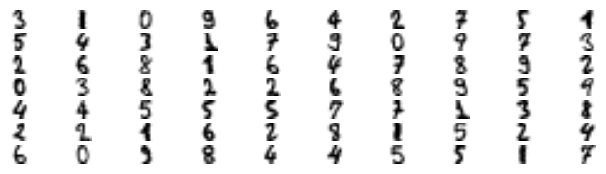

In [8]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary",
               interpolation="bilinear")
    plt.axis('off')

plt.show()

In [9]:
import numpy as np
y_representative_digits = np.array([
    3, 1, 0, 9, 6, 4, 2, 7, 5, 1,
    5, 4, 3, 1, 7, 9, 0, 9, 7, 3,
    2, 6, 8, 1, 6, 4, 7, 8, 9, 2,
    0, 3, 8, 2, 2, 6, 8, 9, 5, 9,
    4, 4, 5, 5, 5, 7, 7, 1, 3, 8,
    2, 2, 1, 6, 2, 8, 1, 5, 2, 4,
    6, 0, 9, 8, 4, 4, 5, 5, 1, 7
])
#y_representative_digits = y_train[representative_digit_idx]
print(y_representative_digits)

[3 1 0 9 6 4 2 7 5 1 5 4 3 1 7 9 0 9 7 3 2 6 8 1 6 4 7 8 9 2 0 3 8 2 2 6 8
 9 5 9 4 4 5 5 5 7 7 1 3 8 2 2 1 6 2 8 1 5 2 4 6 0 9 8 4 4 5 5 1 7]


In [10]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8944723618090452

## 대표 이미지와 같은 군의 이미지에 동일한 레이블을 붙여서 학습

1200개 학습이미지에 같은 군에 대표이미지와 같은 레이블을 붙여 학습

학습 결과 0.915

In [11]:
y_train_propagated = np.empty(len(X_train), dtype=np.int64)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

log_reg = LogisticRegression(max_iter=10000, n_jobs=100)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.914572864321608

## 아웃라이어 5%를 제거하고 학습

각 이미지들에 대해 각자의 대표이미지로부터의 거리를 구해서 가장 거리가 먼 5% 이미지를 제거하고 나머지만 학습

학습결과 0.921

In [12]:
percentile_closest = 95

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1 #이상값으로 배제

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [13]:
partially_propagated.sum()

np.int64(1114)

In [14]:
log_reg = LogisticRegression(max_iter=4000, n_jobs=100)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9212730318257957

In [15]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

np.float64(0.9793536804308797)

## 이상치를 배제하고, 1200개 학습레이블의 정답으로만 학습한경우

정답으로 레이블이 달린것중 이상치를 배제하고 학습해도

군집의 대표레이블을 달고 학습한 결과보다 부족하게 나옴

In [16]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train[partially_propagated]

log_reg = LogisticRegression(max_iter=4000, n_jobs=100)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9195979899497487

In [17]:
(y_train_partially_propagated == y_train[partially_propagated]).mean()

np.float64(1.0)